In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-04-05 22:30:33.659924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Pretraining

In [58]:
root = './presentation/results/lfgr/2024-03-26_04-14-20/'

astromer, config = load_pt_model(os.path.join(root, 'pretraining'))
config['data']

2024-04-02 20:35:36.314622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-02 20:35:36.314666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 99b123e2fc75
2024-04-02 20:35:36.314676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 99b123e2fc75
2024-04-02 20:35:36.314881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-04-02 20:35:36.314924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.104.5
2024-04-02 20:35:36.315273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-04-02 20:35:36,622 - WARNING - From /usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[INFO] Masking Query tokens only
[INFO] Masking Query tokens only


'./data/records/macho_clean/'

In [59]:
pd.DataFrame(config, index=[0])[['arch', 'mask_format', 'probed', 'same', 'scheduler', 'use_leak', 'lr', 'num_heads']]

,arch,mask_format,probed,same,scheduler,use_leak,lr,num_heads
0,base,Q,0.5,0.2,False,True,0.00001,4


In [17]:
data_path = './data/records/macho_clean/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=False,
                       sampling=False,
                       normalize='zero-mean')

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


In [18]:
output = astromer.predict(loaders['test'].take(4))

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only
4/4 [==============================] - 2s 146ms/step


In [19]:
y = tf.ragged.boolean_mask(output['magnitudes'], output['probed_mask'])
y_hat = tf.ragged.boolean_mask(output['reconstruction'], output['probed_mask'])

r2_values = []
mse_values = []
for i in range(output['magnitudes'].shape[0]):
    y = tf.boolean_mask(output['magnitudes'][i], output['probed_mask'][i])
    y_hat = tf.boolean_mask(output['reconstruction'][i], output['probed_mask'][i])
    r2_values.append(r2_score(y, y_hat))
    mse_values.append(mean_squared_error(y, y_hat, squared=False))
    
test_r2   = np.mean(r2_values) 
test_mse = np.mean(mse_values)

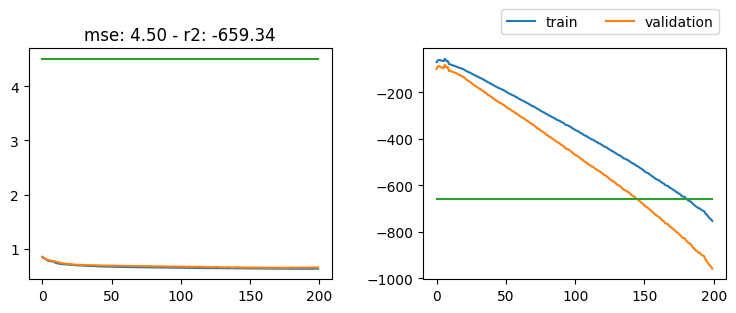

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'wspace':0.3})

for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    train_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'train'), 
                                metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'validation'), 
                                metric_name=metric_name)
    axes[i].plot(train_metrics['step'], train_metrics['value'], label='train')
    axes[i].plot(valid_metrics['step'], valid_metrics['value'], label='validation')
    
    if metric_name == 'epoch_r_square':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_r2, test_r2])
        continue
        
    if metric_name == 'epoch_loss':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_mse, test_mse])
        continue
        
    axes[i].set_ylabel(metric_name)
    axes[i].set_xlabel('Epoch')
    
axes[0].set_title('mse: {:.2f} - r2: {:.2f}'.format(test_mse, test_r2))
axes[-1].legend(bbox_to_anchor=(1., 1.2), ncols=2)
plt.show()

Text(0.5, 1.0, 'True vs Predicted')

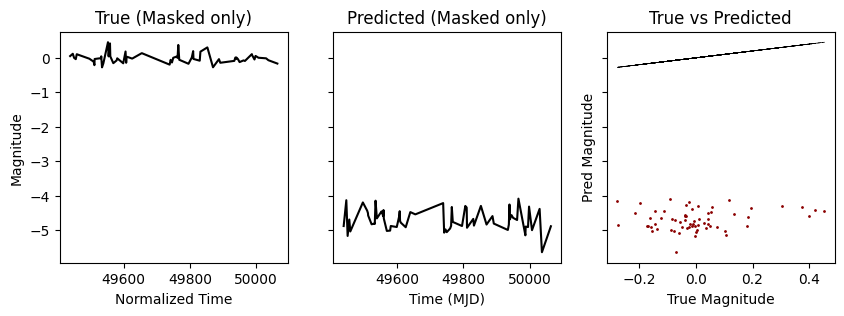

In [21]:
N = 1

x_true = tf.boolean_mask(output['magnitudes'][N], output['mask_in'][N])
x_pred = tf.boolean_mask(output['reconstruction'][N], output['mask_in'][N])
times = tf.boolean_mask(output['times'][N], output['mask_in'][N])

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.2}, sharey=True)
axes[0].plot(times, x_true, color='k', label='True')
axes[0].set_title('True (Masked only)')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlabel('Normalized Time')
axes[1].plot(times, x_pred, color='k', label='Prediction')
axes[1].set_title('Predicted (Masked only)')
axes[1].set_xlabel('Time (MJD)')
axes[2].scatter(x_true, x_pred, s=1, color='darkred')
axes[2].plot(x_true, x_true, linewidth=0.5, color='k', linestyle='--')

axes[2].set_xlabel('True Magnitude')
axes[2].set_ylabel('Pred Magnitude')
axes[2].set_title('True vs Predicted')

## Finetunem (MLFlow)

In [22]:
runs_df = mlflow.search_runs(experiment_ids=['334210612378422708'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']
runs_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.test_acc', 'metrics.test_recall',
       'metrics.test_precision', 'metrics.test_f1',
       ...
       'tags.correct_loss', 'tags.bs', 'tags.data', 'tags.pt_weights',
       'tags.spc', 'tags.debug', 'tags.gpu', 'tags.lr', 'tags.head_dim',
       'tags.mixer'],
      dtype='object', length=104)

In [7]:
# id_cols = ['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']
    
# selected = runs_df[id_cols+['tags.fold', 'metrics.val_rmse', 'metrics.test_r2']]

# selected.groupby(id_cols).agg({'metrics.val_rmse': ['mean', 'std'],
#                                                                           'metrics.test_r2': ['mean', 'std']})

## Classification (MLFlow)

In [32]:
runs_df = mlflow.search_runs(experiment_ids=['209137595870989300'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

runs_df = runs_df[['tags.downstream_data', 'params.mask_format','params.loss_format', 'params.correct_loss', 'params.norm', 'tags.m_alpha', 
                   'tags.probed', 'tags.rs', 'tags.same', 'tags.spc', 
                   'tags.fold', 'metrics.test_f1']]
runs_df['tags.fold'] = runs_df['tags.fold'].astype(float)
runs_df['metrics.test_f1'] = runs_df['metrics.test_f1'].astype(float)
runs_df = runs_df[~runs_df['tags.downstream_data'].isna()]

In [33]:
runs_df['params.loss_format'] = runs_df['params.loss_format'].astype('string')

In [34]:
grouped = runs_df.groupby(
    ['tags.downstream_data', 'params.correct_loss','params.loss_format', 'params.mask_format', 'params.norm', 
     'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']).agg({'metrics.test_f1': ['mean', 'std']})

In [35]:
grouped

metrics.test_f1  \
                                                                                                                                                           mean   
tags.downstream_data params.correct_loss params.loss_format params.mask_format params.norm tags.m_alpha  tags.probed tags.rs tags.same tags.spc                   
atlas                False               rmse               Q                  random-mean -1000000000.0 0.2         0.18    0.18      100             0.362369   
                                                                                                                                       20              0.266074   
                                                                                                                                       500             0.383771   
                                                            tanh               zero-mean   -1000000000.0 0.5         0.2     0.2       100             0.362154   
                                                                                                                                       20              0.278967   
                                                                                                                                       500             0.384520   
                     True                rmse               logits             zero-mean   -1000000000.0 0.5         0.2     0.2       100             0.325698   
                                                                                                                                       20              0.274169   
                                                                                                                                       500             0.413174   
macho                False               rmse               Q                  random-mean -1000000000.0 0.2         0.18    0.18      100             0.225056   
                                                                                                                                       20              0.058116   
                                                                                                                                       500             0.259761   
                                                            tanh               zero-mean   -1000000000.0 0.5         0.2     0.2       100             0.548399   
                                                                                                                                       20              0.482623   
                                                                                                                                       500             0.638963   
                     True                rmse               logits             zero-mean   -1000000000.0 0.5         0.2     0.2       100             0.541076   
                                                                                                                                       20              0.302034   
                                                                                                                                       500             0.630545   

                                                                                                                                                           
                                                                                                                                                      std  
tags.downstream_data params.correct_loss params.loss_format params.mask_format params.norm tags.m_alpha  tags.probed tags.rs tags.same tags.spc            
atlas                False               rmse               Q                  random-mean -1000000000.0 0.2         0.18    0.18      100       0.024659  
                                                                                                

  tags.downstream_data params.correct_loss params.loss_format  \
                                                                
1                atlas               False               rmse   
4                atlas               False               rmse   
7                atlas                True               rmse   

  params.mask_format  params.norm   tags.m_alpha tags.probed tags.rs  \
                                                                       
1                  Q  random-mean  -1000000000.0         0.2    0.18   
4               tanh    zero-mean  -1000000000.0         0.5     0.2   
7             logits    zero-mean  -1000000000.0         0.5     0.2   

  tags.same tags.spc metrics.test_f1            
                                mean       std  
1      0.18       20        0.266074  0.070468  
4       0.2       20        0.278967  0.026827  
7       0.2       20        0.274169  0.011062  
   tags.downstream_data params.correct_loss params.loss_format  \
  

/tmp/ipykernel_1530237/3260895526.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alpha'] = df['alpha'].replace({'-1000000000.0': '-inf'})
/tmp/ipykernel_1530237/3260895526.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alpha'] = df['alpha'].replace({'-1000000000.0': '-inf'})


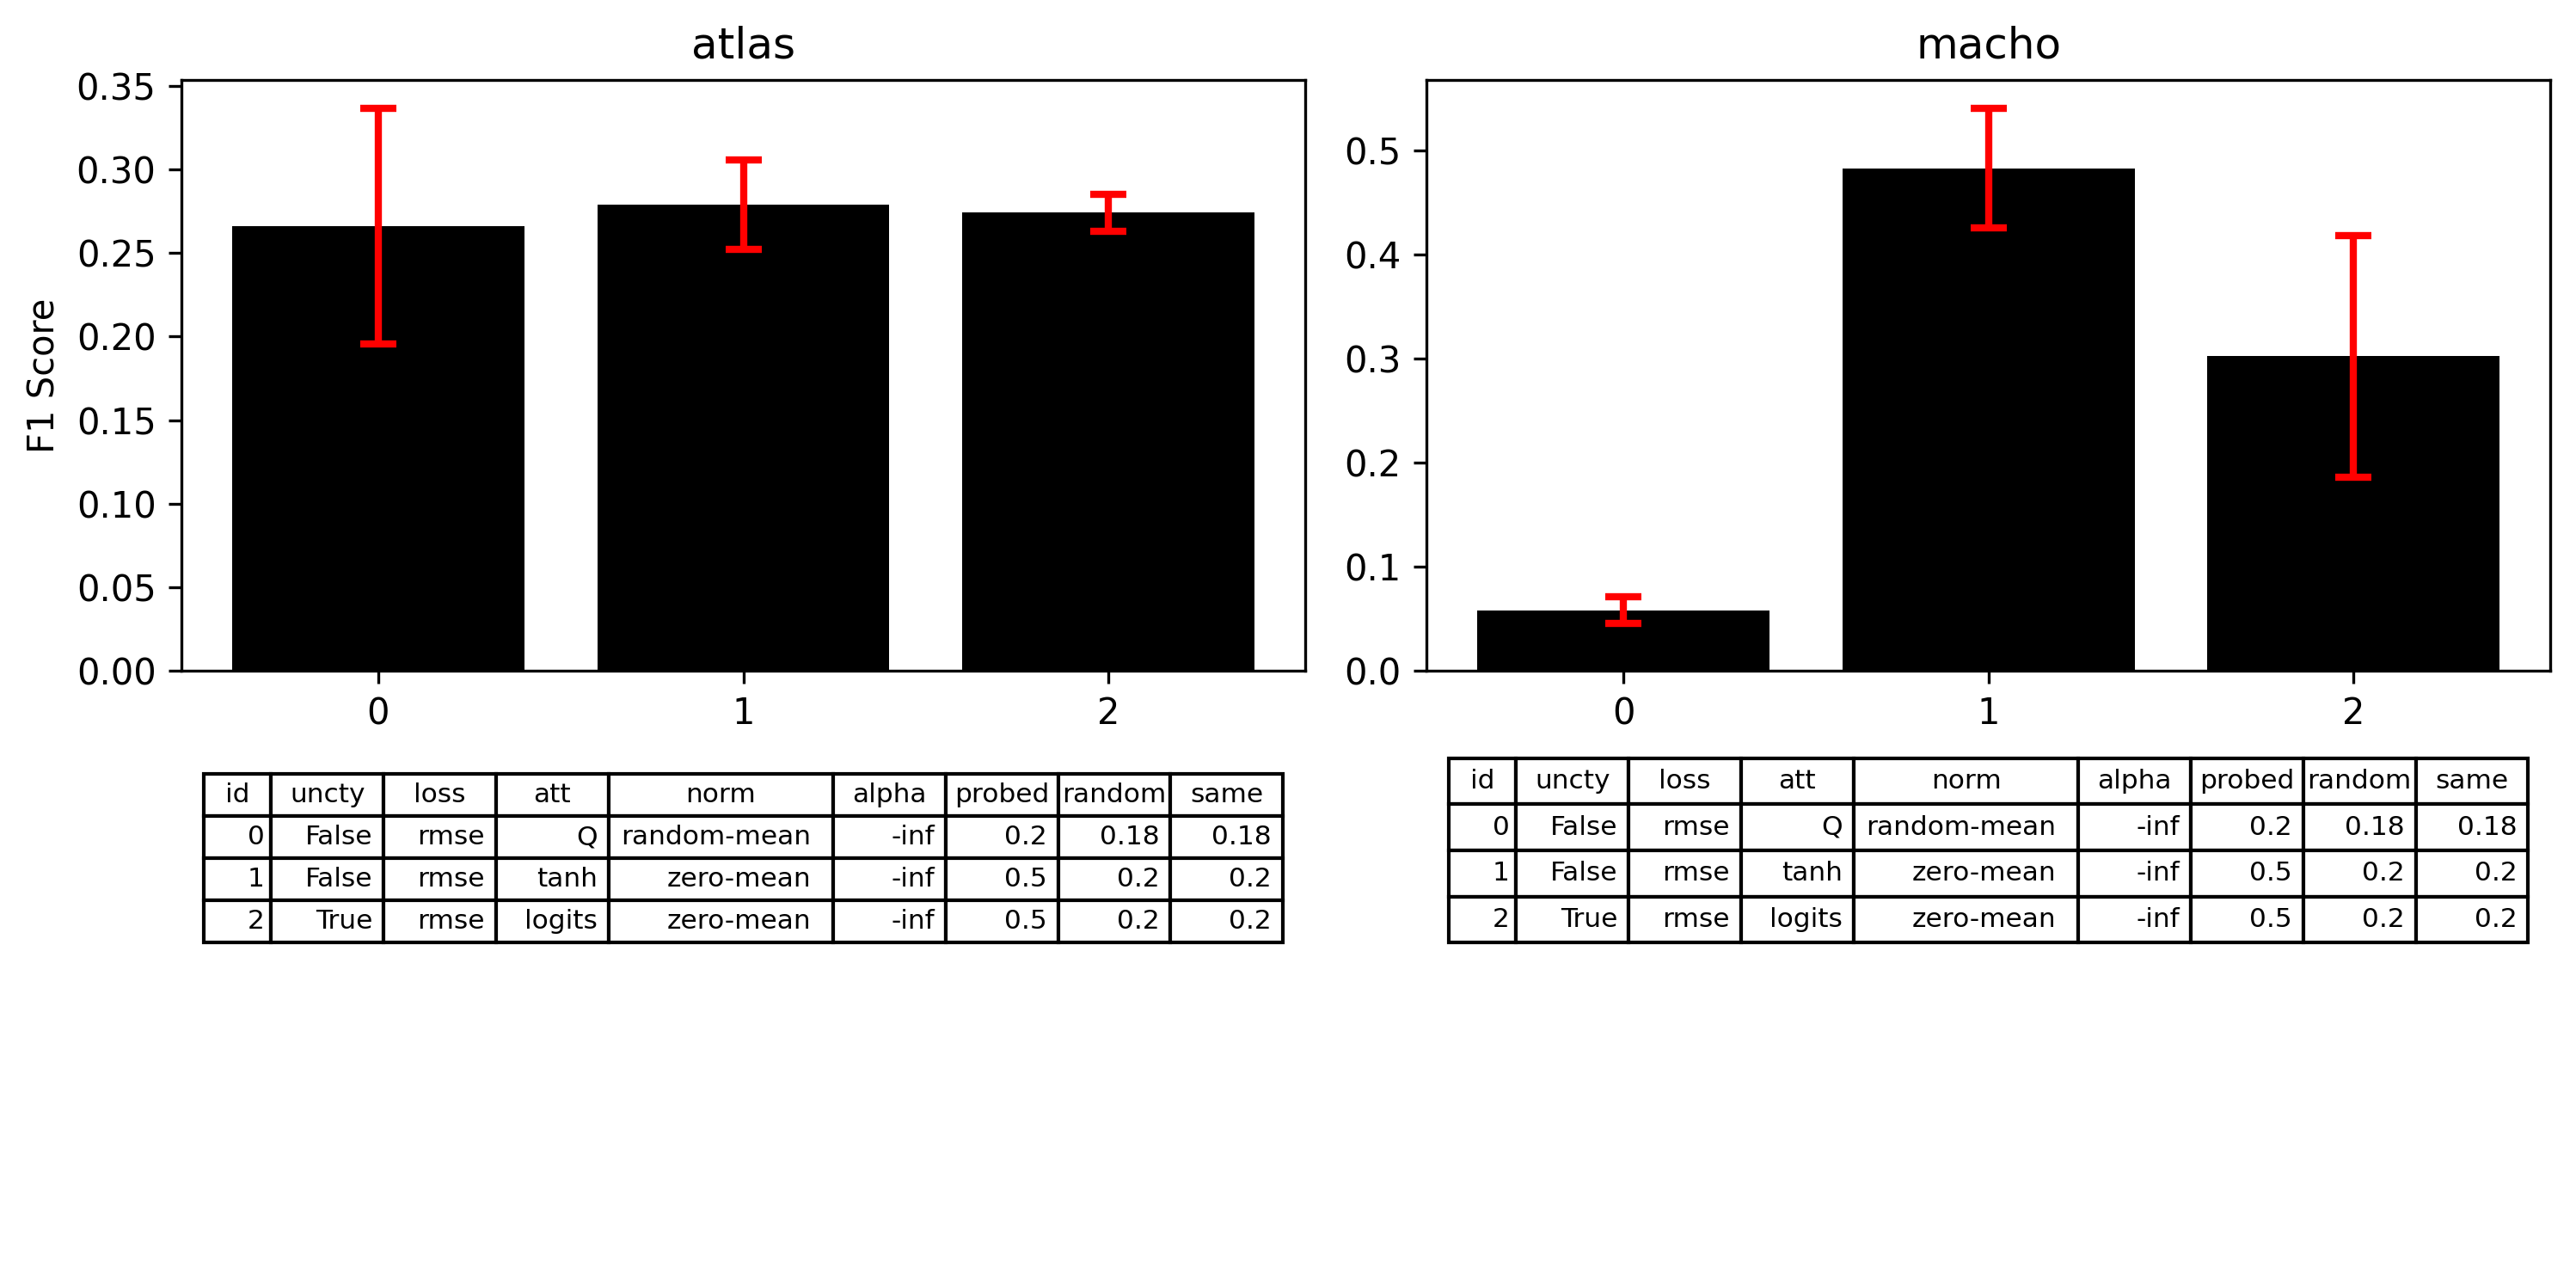

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=300, gridspec_kw={'height_ratios': [2, 1]})

# fig.patch.set_visible(False)
for i, (ds_name, frame) in enumerate(grouped.reset_index().groupby('tags.downstream_data')):
    frame = frame[frame['tags.spc']=='20']
    print(frame)
    axes[0, i].bar(range(frame.shape[0]), frame['metrics.test_f1']['mean'], 
                   yerr=frame['metrics.test_f1']['std'], color='k',
                   error_kw=dict(ecolor='red', lw=2, capsize=5, capthick=2))
    axes[0, i].set_title(ds_name)
    axes[0, i].set_xticks(range(frame.shape[0]))
    frame.index = range(len(frame))
    frame = frame.reset_index()

    df = frame[['index', 'params.correct_loss','params.loss_format', 
                'params.mask_format', 'params.norm', 'tags.m_alpha', 
                'tags.probed', 'tags.rs', 'tags.same']]
    df = df
    df.columns = ['id','uncty', 'loss', 'att', 'norm', 'alpha', 'probed', 'random', 'same']
    
    df['alpha'] = df['alpha'].replace({'-1000000000.0': '-inf'})
    tab = axes[1, i].table(cellText=df.values, 
                           colWidths=[0.03, 0.05, 0.05, 0.05, 0.1, 0.05, 0.05, 0.05, 0.05],
                           colLabels=df.columns, 
                           loc='top')
    axes[1, i].axis('tight')
    axes[1, i].axis('off')
    
    tab.auto_set_font_size(False)
    tab.set_fontsize(7.5)
    tab.scale(2, 1)
    axes[0, 0].set_ylabel('F1 Score')
    fig.tight_layout()

In [12]:
frame

index tags.downstream_data params.correct_loss params.loss_format  \
                                                                      
0     0                macho               False               rmse   
1     1                macho               False               rmse   
2     2                macho                True               rmse   

  params.mask_format  params.norm   tags.m_alpha tags.probed tags.rs  \
                                                                       
0                  Q  random-mean  -1000000000.0         0.2    0.18   
1               tanh    zero-mean  -1000000000.0         0.5     0.2   
2             logits    zero-mean  -1000000000.0         0.5     0.2   

  tags.same tags.spc metrics.test_f1            
                                mean       std  
0      0.18      500        0.259761  0.027117  
1       0.2      500        0.638963  0.002455  
2       0.2      500        0.630545  0.013578